<a href="https://colab.research.google.com/github/Nataliahfk/estadistica_python/blob/main/optimizaci%C3%B3n_vuelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Desarrollar un modelo que nos permita prever el atraso con el menor tiempo posible.Esto quiere decir, que si un vuelo se atrasa yo tengo un margen de tiempo dentro de ese periodo que me permitira poder establecer si este vuelo saldrá edentro del horario.

Esto ayuda a reducir costos y mantener una buena satisfaccion del cliente.

In [3]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import yellowbrick

print(f'Versión de pandas: {pd.__version__}')
print(f'Versión de numpy: {np.__version__}')
print(f'Versión de scikit-learn (sklearn): {sklearn.__version__}')
print(f'Versión de seaborn: {sns.__version__}')
print(f'Versión de yellowbrick: {yellowbrick.__version__}')

Versión de pandas: 2.2.2
Versión de numpy: 2.0.2
Versión de scikit-learn (sklearn): 1.6.1
Versión de seaborn: 0.13.2
Versión de yellowbrick: 1.5


In [4]:
datos = pd.read_csv('/content/flights.csv')
datos

,flight_id,airline,aircraft_type,schengen,origin,arrival_time,departure_time,day,year,is_holiday,delay
0,26,MM,Airbus A320,non-schengen,TCY,8.885071,10.885071,0,2010,False,70.205981
1,10,YE,Airbus A320,non-schengen,TCY,8.939996,11.939996,0,2010,False,38.484609
2,3,BZ,Embraer E175,schengen,TZF,18.635384,22.635384,0,2010,False,2.388305
3,28,BZ,Airbus A330,non-schengen,EMM,15.967963,17.967963,0,2010,False,19.138491
4,15,BZ,Airbus A330,non-schengen,FJB,16.571894,19.571894,0,2010,False,15.016271
...,...,...,...,...,...,...,...,...,...,...,...
71170,3,BZ,Embraer E175,schengen,TZF,18.635384,22.635384,364,2022,True,25.677277
71171,17,BZ,Airbus A330,non-schengen,CNU,16.718722,21.718722,364,2022,True,52.624348
71172,7,MM,Boeing 787,schengen,TZF,8.564949,13.564949,364,2022,True,56.167080
71173,5,BZ,Airbus A320,schengen,ZQO,9.344097,12.344097,364,2022,True,56.758844


In [6]:
datos.shape

(71175, 11)

In [10]:
# para calcular los segundos
round(.88*60)

53

In [11]:
round(.20*60)

12

Ejemplo de los horarios:

- hora de llegada: 8.885071	 // 8:53
- hora de salida: 10.885071	 // 10:53
- retraso : 70.205981    //  70 min con 20 segundos


In [12]:
datos = datos.rename(columns={
    'flight_id': 'ID_vuelo',
    'airline': 'Aerolínea',
    'aircraft_type': 'Tipo_aeronave',
    'schengen': 'Schengen',
    'origin': 'Origen',
    'arrival_time': 'Hora_llegada',
    'departure_time': 'Hora_salida',
    'day': 'Día',
    'year': 'Año',
    'is_holiday': 'Es_feriado',
    'delay': 'Retraso'
})

In [13]:
datos

,ID_vuelo,Aerolínea,Tipo_aeronave,Schengen,Origen,Hora_llegada,Hora_salida,Día,Año,Es_feriado,Retraso
0,26,MM,Airbus A320,non-schengen,TCY,8.885071,10.885071,0,2010,False,70.205981
1,10,YE,Airbus A320,non-schengen,TCY,8.939996,11.939996,0,2010,False,38.484609
2,3,BZ,Embraer E175,schengen,TZF,18.635384,22.635384,0,2010,False,2.388305
3,28,BZ,Airbus A330,non-schengen,EMM,15.967963,17.967963,0,2010,False,19.138491
4,15,BZ,Airbus A330,non-schengen,FJB,16.571894,19.571894,0,2010,False,15.016271
...,...,...,...,...,...,...,...,...,...,...,...
71170,3,BZ,Embraer E175,schengen,TZF,18.635384,22.635384,364,2022,True,25.677277
71171,17,BZ,Airbus A330,non-schengen,CNU,16.718722,21.718722,364,2022,True,52.624348
71172,7,MM,Boeing 787,schengen,TZF,8.564949,13.564949,364,2022,True,56.167080
71173,5,BZ,Airbus A320,schengen,ZQO,9.344097,12.344097,364,2022,True,56.758844


In [15]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71175 entries, 0 to 71174
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID_vuelo       71175 non-null  int64  
 1   Aerolínea      71175 non-null  object 
 2   Tipo_aeronave  71175 non-null  object 
 3   Schengen       71175 non-null  object 
 4   Origen         71175 non-null  object 
 5   Hora_llegada   71175 non-null  float64
 6   Hora_salida    71175 non-null  float64
 7   Día            71175 non-null  int64  
 8   Año            71175 non-null  int64  
 9   Es_feriado     71175 non-null  bool   
 10  Retraso        71175 non-null  float64
dtypes: bool(1), float64(3), int64(3), object(4)
memory usage: 5.5+ MB


In [16]:
# Variables numericas
datos.describe()

,ID_vuelo,Hora_llegada,Hora_salida,Día,Año,Retraso
count,71175.000000,71175.000000,71175.000000,71175.000000,71175.000000,71175.000000
mean,15.465135,13.283159,16.480222,182.000000,2016.000000,12.548378
std,8.649646,4.023380,4.143705,105.366769,3.741684,23.125349
min,1.000000,7.065594,10.065594,0.000000,2010.000000,-41.028033
25%,8.000000,8.939996,12.668655,91.000000,2013.000000,-4.412876
50%,15.000000,14.258911,16.376052,182.000000,2016.000000,9.740454
75%,23.000000,16.909690,20.041281,273.000000,2019.000000,27.650853
max,30.000000,19.341235,23.341235,364.000000,2022.000000,125.632352


en la columna retraso aparece:
- min con un valor -41.028033 eso significa que el vuelo salio con 41 minutos de adelanto.
- 25% el primer quartil, o el primer 25% salio con -4.412876 app 4 min 20 segundos adelantado
- La mediana 50% o segundo quantil tengo app 9.740454 un atraso de 9 min 45 seg
- el 75% tiene un retraso de 27.650853 eso es 27 min con 40 seg
- y el max son 125 min con 40 seg. que es + de 2 hrs.


Lo que genera perdidas, molestias de los pasajeros, etc.



In [18]:
# variables categoricas
datos.describe(include='object')

,Aerolínea,Tipo_aeronave,Schengen,Origen
count,71175,71175,71175,71175
unique,3,6,2,10
top,BZ,Airbus A320,schengen,TZF
freq,47598,30778,42569,14162


- unique muestra que hay 3 aerolineas, 6 tipos de naves, 2 Schengen (sí, no) y 10 aeropuertos de origen
- top muestra que la aerolinea que mas se presenta en los datos es BZ, el tipo de avion es AirbusA320,  Schengen y el aeropuerto de origen es TZF.
- freq es la frecuencia del top.

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
promedio_retraso = datos.groupby('Aerolínea')['Retraso'].mean().reset_index() # .reset_index() para no dejarlo como indice, sino como columna
promedio_retraso

,Aerolínea,Retraso
0,BZ,3.077595
1,MM,40.498007
2,YE,25.772248


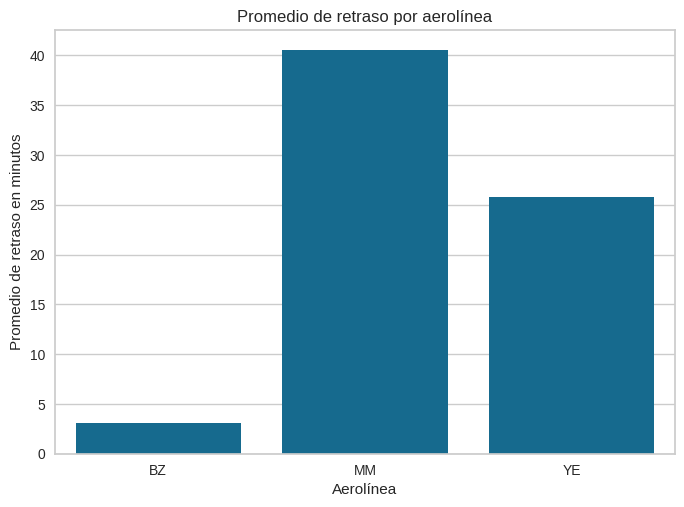

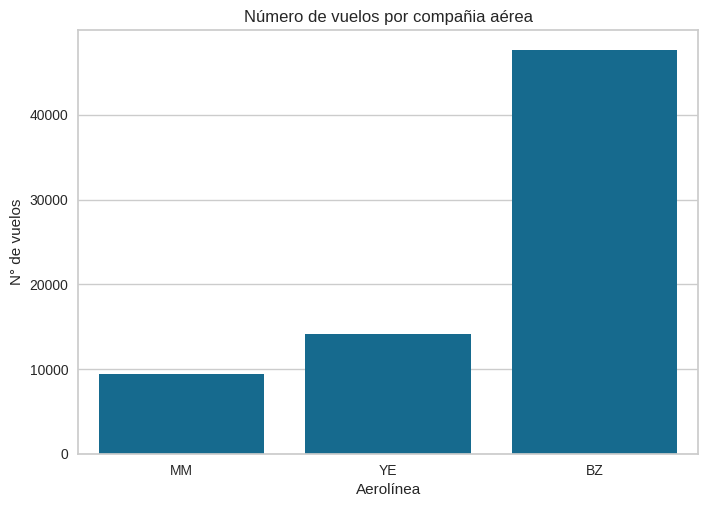

In [22]:
sns.barplot(x='Aerolínea', y='Retraso', data=promedio_retraso)
plt.title('Promedio de retraso por aerolínea')
plt.xlabel('Aerolínea')
plt.ylabel('Promedio de retraso en minutos')
plt.show()

sns.countplot(x='Aerolínea', data=datos)
plt.title('Número de vuelos por compañia aérea')
plt.xlabel('Aerolínea')
plt.ylabel('N° de vuelos')
plt.show()